# TEXT CLASSIFICATION WITH MULTI-LAYER PERCEPTRONS
# Α Pos Tagger trained on UD treebank

In [176]:
import pyconll, keras, pickle, os, random, nltk, datetime, warnings, gc, urllib.request, zipfile
import numpy as np
from scipy.sparse import hstack, vstack
import matplotlib.pyplot as plt
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import FastText
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, learning_curve, cross_val_score
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, BatchNormalization, Dropout, Input, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils
from sklearn.metrics.classification import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
from numpy.random import seed
from tensorflow import set_random_seed

# Various plot functions

In [2]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [3]:
def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          i=1):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(10, 6))
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

# Load Dataset

In [4]:
UD_ENGLISH_TRAIN = 'en_partut-ud-train.conllu'
UD_ENGLISH_DEV = 'en_partut-ud-dev.conllu'
UD_ENGLISH_TEST = 'en_partut-ud-test.conllu'

In [5]:
def download_files():
    print('Downloading English treebank...')
    urllib.request.urlretrieve('http://archive.aueb.gr:8085/files/en_partut-ud-dev.conllu', 'en_partut-ud-dev.conllu')
    urllib.request.urlretrieve('http://archive.aueb.gr:8085/files/en_partut-ud-test.conllu', 'en_partut-ud-test.conllu')
    urllib.request.urlretrieve('http://archive.aueb.gr:8085/files/en_partut-ud-train.conllu', 'en_partut-ud-train.conllu')
    print('Treebank downloaded.')
    print('Downloading Fasttext pre-trained word embeddings...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip', 'wiki-news-300d-1M.vec.zip')
    print('Pre-trained word embeddings downloaded.')
    print('Extracting zip file...')
    zip_ref = zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r')
    zip_ref.extractall('.')
    zip_ref.close()
    print('Zip file extracted.')

In [6]:
download_files()

Treebank downloaded.
Pre-trained word embeddings downloaded.
Extracting zip file...
Zip file extracted.


# Preprocessing

In [5]:
def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    t=0
    for sentence in data:
        tagged_sentence=[]
        for token in sentence:
            if token.upos:
                t+=1
                tagged_sentence.append((token.form.lower(), token.upos))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences

Load train, development and test set in the appropriate tagged format, tuple (word, pos-tag)

In [6]:
train_sentences = read_conllu(UD_ENGLISH_TRAIN)
val_sentences = read_conllu(UD_ENGLISH_DEV)
test_sentences = read_conllu(UD_ENGLISH_TEST)

Print some statistics

In [7]:
print("Tagged sentences in train set: ", len(train_sentences))
print("Tagged words in train set:", len([item for sublist in train_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in dev set: ", len(val_sentences))
print("Tagged words in dev set:", len([item for sublist in val_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in test set: ", len(test_sentences))
print("Tagged words in test set:", len([item for sublist in test_sentences for item in sublist]))

Tagged sentences in train set:  1781
Tagged words in train set: 43518
Tagged sentences in dev set:  156
Tagged words in dev set: 2722
Tagged sentences in test set:  153
Tagged words in test set: 3408


In [8]:
print(train_sentences[0])

[('distribution', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('license', 'NOUN'), ('does', 'AUX'), ('not', 'PART'), ('create', 'VERB'), ('an', 'DET'), ('attorney', 'NOUN'), ('-', 'PUNCT'), ('client', 'NOUN'), ('relationship', 'NOUN'), ('.', 'PUNCT')]


In [9]:
def tag_sequence(sentences):
    return [[t for w, t in sentence] for sentence in sentences]

def text_sequence(sentences):
    return [[w for w, t in sentence] for sentence in sentences]

def id2word(sentences):
    wordlist = [item for sublist in text_sequence(sentences) for item in sublist]
    id2word = {k:v for k,v in enumerate(wordlist)}
    return id2word

def untag(tagged_sentence):
    return [w for w, _ in tagged_sentence]

def untag_pos(tagged_sentence):
    return [t for _, t in tagged_sentence]

def build_vocab(sentences):
    vocab =set()
    for sentence in sentences:
        for word in untag(sentence):
            vocab.add(word)
    return sorted(list(vocab))

A nice observation: there are 286 terms in validation set not found in train set

In [10]:
list_1 = build_vocab(train_sentences)
list_2 = build_vocab(val_sentences)
diff_list = [item for item in list_2 if item not in list_1]
print('Number of terms not found in train set:',len(diff_list))

Number of terms not found in train set: 286


# Load pretrained word-embeddings

We use fasttext wiki-news vectors to build a dictionary with word as key and its vector as value

In [11]:
embs_path = 'wiki-news-300d-1M.vec'
embeddings = KeyedVectors.load_word2vec_format(embs_path, binary=False)
print(embeddings.vectors.shape)

(999994, 300)


Let see the 10 most frequent terms

In [12]:
w2c = dict()
for item in embeddings.vocab:
    w2c[item]=embeddings.vocab[item].count

In [13]:
dict(sorted(w2c.items(), key=lambda x: x[1],reverse=True)[:10])

{'"': 999986,
 ',': 999994,
 '.': 999992,
 ':': 999985,
 'a': 999987,
 'and': 999991,
 'in': 999988,
 'of': 999990,
 'the': 999993,
 'to': 999989}

# Feature Engineering

In [36]:
dim = embeddings.vectors.shape[1]
pad = np.zeros(dim) # Pad vector
np.random.seed(3) # For reproducibility 
oov =  np.random.uniform(-0.25, 0.25, dim) # Out-of-vocabulary vector

def features_embs(sentence, index, window=1, method='concat'):
    """ sentence: [w1, w2, ...],
        index: the index of the word, 
        window: number of places left and right of the classified word,
        method: sum or concatenate the vectors of words in the window """
    unknown = 0 
    if method == 'sum':
        vec = np.array(dim)
        for i in range(index-window,index+window+1):
            if i<0:
                vec = np.sum([vec, pad], axis=0)
                continue
            if i>len(sentence)-1:
                vec = np.sum([vec, pad], axis=0)
                continue
            try:
                vec = np.sum([vec, embeddings[sentence[i]]], axis=0)
            except:
                vec = np.sum([vec, oov], axis=0)
                unknown +=1
                
    if method == 'concat':
        vec = np.array([])
        for i in range(index-window,index+window+1):
            if i<0:
                vec = np.append(vec, pad) #for word indices out of sentence bounds (begin), append pad vector 
                continue
            if i>len(sentence)-1:
                vec = np.append(vec, pad) #for word indices out of sentence bounds (end), append pad vector
                continue
            try:
                vec = np.append(vec, embeddings[sentence[i]])
            except:
                vec = np.append(vec, oov) #if word is not in embedding model append the oov vector
                unknown +=1
                
    return vec, unknown

In [15]:
def features_basic(sentence, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'nb_terms': len(sentence),        
        'word': sentence[index],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'i-1_prefix-3': '' if index == 0 else sentence[index-1][:3],        
        'i-1_suffix-3': '' if index == 0 else sentence[index-1][-3:],        
        'i+1_prefix-3': '' if index == len(sentence) - 1 else sentence[index+1][:3],        
        'i+1_suffix-3': '' if index == len(sentence) - 1 else sentence[index+1][-3:],        
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
        'capitals_inside': sentence[index][1:].lower() != sentence[index][1:],
    }

In [16]:
def transform_to_dataset(tagged_sentences, window):
    i=0
    X, y = [], []
    for doc_index, tagged in enumerate(tagged_sentences):
        for index in range(len(tagged)):
            X.append([features_basic(untag(tagged), index),\
                      features_embs(untag(tagged), index, window)[0],\
                     ])
            y.append(tagged[index][1])
            #features_embs(untag(tagged), index, window)[1]
            k = features_embs(untag(tagged), index, window)[1]
            i += k
    return X, y, i

In [17]:
def transform_test_sentence(sentence, window):
    X = []
    for index in range(len(sentence)):
            X.append([
                      features_basic(sentence, index),\
                      features_embs(sentence, index, window),\
                     ])
    return X

## Do some tests to see how our untag() and features_embs() functions work

In [18]:
untag(test_sentences[1])

['any',
 'use',
 'of',
 'the',
 'work',
 'other',
 'than',
 'as',
 'authorized',
 'under',
 'this',
 'license',
 'or',
 'copyright',
 'law',
 'is',
 'prohibited',
 '.']

In [19]:
test_sentence = ['This', 'is', 'very', 'good', 'for', 'the', 'world', '!']

In [20]:
print('Shape of vector at index 0 of test_sentence for window size 1:',len(features_embs(test_sentence, 0, window=1, method='concat')[0]))
print('Shape of vector at index 3 of test_sentence for window size 2:',len(features_embs(test_sentence, 0, window=2, method='concat')[0]))

Shape of vector at index 0 of test_sentence for window size 1: 900
Shape of vector at index 3 of test_sentence for window size 2: 1500


In [21]:
print(features_embs(test_sentence, 0, 1)[0])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

# Transformation of dataset

To transform train, dev and test sets we experiment with 3 methods:
1. **Window** based method using pre-trained word embeddings (according to slides 38-39 of "nlp_slides_part03_text_classification_with_mlps.pdf").
2. **Classical** method where for each term we create a dictionary of features depending on the sentence where the term has been extracted from. These features can be the word itself, the word before and the word after, letter suffixes and prefixes, etc.
3. A **boosted** method which is the combination of methods 1 and 2 and seems to give the best results.

In [469]:
def vectorize(train, val, test, window=1, method='embs'):
    """ 
    method can be one of three options:
        'embs': window embeddings
        'classical': dictionary of features depending on the sentence where the term has been extracted from
        'boosted': combination of embs and classical
    """
              
    if method=='embs':
        print('Embeddings window method')
        print('Vectorizing Dataset...')
        print('Vectorizing train...')
        X_train, y_train, unk_tr = transform_to_dataset(train, window=window)
        X_train = [x[1] for x in X_train]
        X_train = np.asarray(X_train)

        print('Vectorizing validation...')
        X_val, y_val, unk_val = transform_to_dataset(val, window=window)
        X_val = [x[1] for x in X_val]
        X_val = np.asarray(X_val)        
        
        print('Vectorizing test...')
        X_test, y_test, unk_te = transform_to_dataset(test, window=window)
        X_test = [x[1] for x in X_test]
        X_test = np.asarray(X_test)
        
        print('Dataset vectorized.')
        print('Train shape:', X_train.shape)
        print('Validation shape:', X_val.shape)
        print('Test shape:', X_test.shape)
        print('Found %s unknown words in train set %s unknown words in validation set and %s unknown words in test set' % (unk_tr, unk_val, unk_te))
        return X_train, y_train, X_val, y_val, X_test, y_test
    
    if method=='classical':
        print('Classical method')
        print('Vectorizing Dataset...')
        print('Vectorizing train...')
        X_train, y_train, _ = transform_to_dataset(train, window=window)
        v = DictVectorizer(sparse=True) 
        X_train = v.fit_transform([x[0] for x in X_train])
        
        print('Vectorizing validation...')
        X_val, y_val, _ = transform_to_dataset(val, window=window)
        X_val = v.transform([x[0] for x in X_val])        
        
        print('Vectorizing test...')
        X_test, y_test, _ = transform_to_dataset(test, window=window)
        X_test = v.transform([x[0] for x in X_test])
        
        print('Dataset vectorized.')
        print('Train shape:', X_train.shape)
        print('Validation shape:', X_val.shape)
        print('Test shape:', X_test.shape)
        X_train = X_train # Because we have sparce matrix
        X_val = X_val # Because we have sparce matrix
        X_test = X_test # Because we have sparce matrix
        return X_train, y_train, X_val, y_val, X_test, y_test, v
    
    if method=='boosted':
        print('Combined Classical - Embeddings window method')
        print('Vectorizing Dataset...')
        print('Vectorizing train...')
        X_train, y_train, unk_tr = transform_to_dataset(train, window=window)
        v = DictVectorizer(sparse=True) # We choose sparse=True for faster concatenation later
        X_classical = v.fit_transform([x[0] for x in X_train])
        X_embs = [x[1] for x in X_train]
        X_embs = np.asarray(X_embs)
        X_train = hstack((X_classical, X_embs))
        del X_classical, X_embs
        
        print('Vectorizing validation...')
        X_val, y_val, unk_val = transform_to_dataset(val, window=window)
        X_classical_val = v.transform([x[0] for x in X_val])
        X_embs_val = [x[1] for x in X_val]
        X_embs_val = np.asarray(X_embs_val)
        X_val = hstack((X_classical_val, X_embs_val)) # We concatenate the feature vectors        
        
        print('Vectorizing test...')
        X_test, y_test, unk_te = transform_to_dataset(test, window=window)
        X_classical_test = v.transform([x[0] for x in X_test])
        X_embs_test = [x[1] for x in X_test]
        X_embs_test = np.asarray(X_embs_test)
        X_test = hstack((X_classical_test, X_embs_test)) # We concatenate the feature vectors
        
        print('Dataset vectorized.')
        print('Train shape:', X_train.shape)
        print('Validation shape:', X_val.shape)
        print('Test shape:', X_test.shape)
        del X_classical_test, X_embs_test
        print('Found %s unknown words in train set %s unknown words in validation set and %s unknown words in test set' % (unk_tr, unk_val, unk_te))
        X_train = X_train.tocsr() # Because we have sparce matrix
        X_val = X_val.tocsr() # Because we have sparce matrix
        X_test = X_test.tocsr() # Because we have sparce matrix
        gc.collect()
        return X_train, y_train, X_val, y_val, X_test, y_test, v

# Baseline tagger

Train and evaluate a Baseline Unigram tagger

In [571]:
default_tagger = nltk.DefaultTagger('NN')
unigram_tagger = nltk.UnigramTagger(train_sentences+val_sentences, backoff=default_tagger)

In [573]:
y_train = [item for sublist in tag_sequence(train_sentences+val_sentences) for item in sublist]
y_test = [item for sublist in tag_sequence(test_sentences) for item in sublist]
classes = sorted(list(set(y_train)))

In [574]:
def tag_list(tagged_sents):
    return [tag for sent in tagged_sents for (word, tag) in sent]
def apply_tagger(tagger, corpus):
    return [tagger.tag(nltk.tag.untag(sent)) for sent in corpus]

In [575]:
y_pred = tag_list(apply_tagger(unigram_tagger, test_sentences))
print("Accuracy: {0:.4f}".format(unigram_tagger.evaluate(test_sentences)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_test, y_pred, average='macro')))

Accuracy: 0.8600
f1-macro score: 0.8261


In [576]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

         ADJ     0.8788    0.7768    0.8246       224
         ADP     0.9452    0.8832    0.9131       488
         ADV     0.9074    0.7481    0.8201       131
         AUX     0.9286    1.0000    0.9630       234
       CCONJ     1.0000    0.9896    0.9948        96
         DET     0.9661    0.9749    0.9705       439
        INTJ     1.0000    1.0000    1.0000         2
          NN     0.0000    0.0000    0.0000         0
        NOUN     0.9549    0.8154    0.8797       753
         NUM     0.9649    0.9016    0.9322        61
        PART     0.5323    1.0000    0.6947        66
        PRON     0.9310    0.7642    0.8394       106
       PROPN     0.8676    0.6556    0.7468        90
       PUNCT     1.0000    1.0000    1.0000       339
       SCONJ     0.6863    0.6863    0.6863        51
        VERB     0.9316    0.6687    0.7786       326
           X     1.0000    1.0000    1.0000         2

   micro avg     0.8600   

See what errors the Baseline tagger makes:

In [577]:
def check_tagger(tagged_sentence):
    note = ''
    for tup in list(zip(unigram_tagger.tag(untag(tagged_sentence)),untag_pos(tagged_sentence))):
        if tup[0][1]!=tup[1]: note='<<--- Error!'
        print(tup[0], tup[1], note)
        note=''

In [578]:
check_tagger(test_sentences[1])

('any', 'DET') DET 
('use', 'NOUN') NOUN 
('of', 'ADP') ADP 
('the', 'DET') DET 
('work', 'NOUN') NOUN 
('other', 'ADJ') ADJ 
('than', 'ADP') SCONJ <<--- Error!
('as', 'ADP') ADP 
('authorized', 'NN') VERB <<--- Error!
('under', 'ADP') ADP 
('this', 'DET') DET 
('license', 'NOUN') NOUN 
('or', 'CCONJ') CCONJ 
('copyright', 'NOUN') NOUN 
('law', 'NOUN') NOUN 
('is', 'AUX') AUX 
('prohibited', 'VERB') VERB 
('.', 'PUNCT') PUNCT 


It makes some mistakes!

In [579]:
cnf_matrix = confusion_matrix(y_test, y_pred)
name='Baseline'

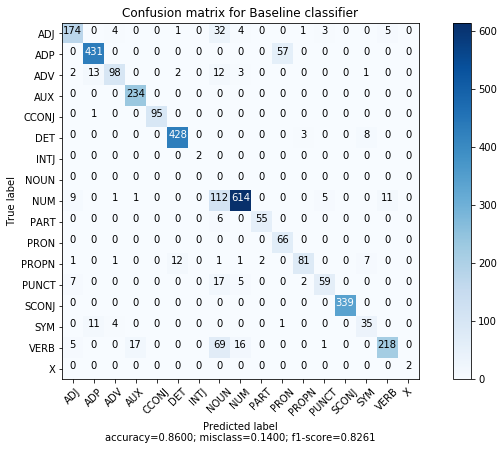

In [580]:
plot_confusion_matrix(f1_score(y_test, y_pred, average='macro'), cnf_matrix, target_names=classes, title='Confusion matrix for '+name+' classifier', normalize=False)

# Train a logistic regression model (PART A)

First transform dataset selecting a representation method.

## Method 1

In [549]:
X_train, y_train, X_val, y_val, X_test, y_test = vectorize(train_sentences, val_sentences, test_sentences, 
                                                           window=1, method='embs')

Embeddings window method
Vectorizing Dataset...
Vectorizing train...
Vectorizing validation...
Vectorizing test...
Dataset vectorized.
Train shape: (43518, 900)
Validation shape: (2722, 900)
Test shape: (3408, 900)
Found 1473 unknown words in train set 78 unknown words in validation set and 50 unknown words in test set


## Method 2

In [217]:
X_train, y_train, X_val, y_val, X_test, y_test, vec = vectorize(train_sentences, val_sentences, test_sentences, method='classical')

Classical method
Vectorizing Dataset...
Vectorizing train...
Vectorizing validation...
Vectorizing test...
Dataset vectorized.
Train shape: (43518, 28727)
Validation shape: (2722, 28727)
Test shape: (3408, 28727)


## Method 3

In [179]:
X_train, y_train, X_val, y_val, X_test, y_test, vec = vectorize(train_sentences, val_sentences, test_sentences, window=2, method='boosted')

Combined Classical - Embeddings window method
Vectorizing Dataset...
Vectorizing train...
Vectorizing validation...
Vectorizing test...
Dataset vectorized.
Train shape: (43518, 30227)
Validation shape: (2722, 30227)
Test shape: (3408, 30227)
Found 2391 unknown words in train set 123 unknown words in validation set and 79 unknown words in test set


## Hyper parameter tuning

Because we will use cross-validation, we can use the full train set (train + validation)

In [550]:
X_train = vstack((X_train, X_val))
y_train = np.append(y_train, y_val, axis=0)

In [551]:
X_train.shape

(46240, 900)

In [552]:
y_train.shape

(46240,)

In [38]:
def hyper_tuning(train, test, y_train, y_test, scores, estimator, parameters, cv):
    print("# Estimator:",estimator)
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)        
        clf = GridSearchCV(estimator, parameters, cv=cv, scoring='%s' % score)
        clf.fit(train, y_train)
        print("Best parameters set found on development set:")
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()
        print("Detailed classification report:")
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        y_pred = clf.predict(test)
        print(classification_report(y_test, y_pred, digits=4))
        print('Accuracy: {0:0.4f}   f1-score: {1:0.4f} \n'.format(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro')))
    return clf

In [40]:
logregr = LogisticRegression(solver='liblinear', multi_class='auto', random_state=13)
# Cross validation strategy
skf = StratifiedKFold(n_splits=5, random_state=1)
# Scores could also be ['precision', 'recall', ....]
scores = ['accuracy', 'f1_macro']

params = [{'C': [0.1, 1, 2, 3]}]
#logregr = hyper_tuning(X_train, X_test, y_train, y_test, scores, logregr, params, skf)
#You may want to comment previous line and comment-out next lines to see how hyper-tuning works and dont wait too much time...
skf = StratifiedKFold(n_splits=5, random_state=1)
logregr = hyper_tuning(X_train[:500], X_test[:50], y_train[:500], y_test[:50], scores, logregr, params, skf)

# Estimator: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=13, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
# Tuning hyper-parameters for accuracy


c:\program files\python36\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
c:\program files\python36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'C': 1}

Grid scores on development set:
0.766 (+/-0.084) for {'C': 0.1}
0.886 (+/-0.065) for {'C': 1}
0.886 (+/-0.051) for {'C': 2}
0.886 (+/-0.045) for {'C': 3}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

         ADJ     0.0000    0.0000    0.0000         1
         ADP     0.8889    1.0000    0.9412         8
         ADV     1.0000    1.0000    1.0000         1
         AUX     0.5000    1.0000    0.6667         1
       CCONJ     0.7500    1.0000    0.8571         3
         DET     1.0000    1.0000    1.0000         7
        NOUN     0.8667    1.0000    0.9286        13
         NUM     0.0000    0.0000    0.0000         1
       PROPN     1.0000    1.0000    1.0000         1
       PUNCT     1.0000    1.0000    1.0000         5
       SCONJ     0.0000    0.0000    0.0000         2
      

c:\program files\python36\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
c:\program files\python36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'C': 3}

Grid scores on development set:
0.517 (+/-0.134) for {'C': 0.1}
0.753 (+/-0.132) for {'C': 1}
0.753 (+/-0.112) for {'C': 2}
0.765 (+/-0.091) for {'C': 3}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

         ADJ     1.0000    1.0000    1.0000         1
         ADP     1.0000    1.0000    1.0000         8
         ADV     1.0000    1.0000    1.0000         1
         AUX     1.0000    1.0000    1.0000         1
       CCONJ     0.7500    1.0000    0.8571         3
         DET     1.0000    1.0000    1.0000         7
        NOUN     0.8667    1.0000    0.9286        13
         NUM     0.0000    0.0000    0.0000         1
       PROPN     1.0000    1.0000    1.0000         1
       PUNCT     1.0000    1.0000    1.0000         5
       SCONJ     0.0000    0.0000    0.0000         2
      

## Training

In [553]:
t_ini = datetime.datetime.now()
print('Training...')
clf = LogisticRegression(C=1, solver='liblinear', multi_class='auto', random_state=13)
clf.fit(X_train, y_train)
t_fin = datetime.datetime.now()
print('Training completed in {} seconds'.format((t_fin - t_ini).total_seconds()))

Training...
Training completed in 124.275567 seconds


# Evaluation

In [554]:
y_pred = clf.predict(X_test)

In [555]:
print("Accuracy: {0:.4f}".format(clf.score(X_test, y_test)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_test, y_pred, average='macro')))

Accuracy: 0.9542
f1-macro score: 0.8790


## Classification report

In [44]:
print(classification_report(y_test, clf.predict(X_test), digits=4))

              precision    recall  f1-score   support

         ADJ     0.8643    0.8527    0.8584       224
         ADP     0.9509    0.9918    0.9709       488
         ADV     0.9076    0.8244    0.8640       131
         AUX     0.9748    0.9915    0.9831       234
       CCONJ     1.0000    0.9896    0.9948        96
         DET     0.9909    0.9886    0.9897       439
        INTJ     0.0000    0.0000    0.0000         2
        NOUN     0.9605    0.9681    0.9643       753
         NUM     0.9836    0.9836    0.9836        61
        PART     0.9552    0.9697    0.9624        66
        PRON     0.9245    0.9245    0.9245       106
       PROPN     0.9024    0.8222    0.8605        90
       PUNCT     0.9971    1.0000    0.9985       339
       SCONJ     0.8571    0.7059    0.7742        51
        VERB     0.9301    0.9387    0.9344       326
           X     1.0000    1.0000    1.0000         2

   micro avg     0.9542    0.9542    0.9542      3408
   macro avg     0.8874   

## Frequent types of mistakes

In [28]:
import collections
k=0
i2w = id2word(test_sentences)
error_counter = collections.Counter()
for i in range(X_test.shape[0]):
    correct_tag_id = y_test
    if y_pred[i]!=y_test[i]:
        k += 1
        word = i2w[i]
        error_counter[word] += 1
print('Accuracy: {0:.4f}'.format((len(i2w)-k)/len(i2w)))
print('Total errors/Total words: {}/{}\n'.format(k,len(i2w)))
print('Most common errors:',error_counter.most_common(20))

Accuracy: 0.9542
Total errors/Total words: 156/3408

Most common errors: [('as', 13), ('to', 6), ('that', 6), ('appointed', 5), ('part', 3), ('national', 3), ('justice', 3), ('general', 3), ('is', 2), ('yes', 2), ('further', 2), ('contracting', 2), ('subject', 2), ('bulgarian', 2), ('romanian', 2), ('thereto', 2), ('no', 2), ('longer', 2), ('base', 2), ('than', 1)]


## Learning curves

<module 'matplotlib.pyplot' from 'c:\\program files\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

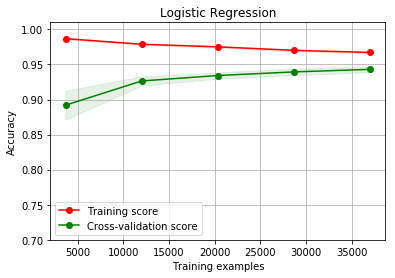

In [46]:
plot_learning_curve(clf, 'Logistic Regression', X_train, y_train, ylim=(0.7, 1.01), cv=5)

## Confusion matrix

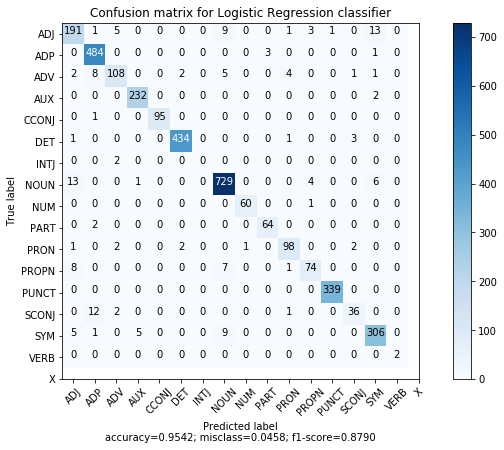

In [581]:
y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')
cnf_matrix = confusion_matrix(y_test, y_pred)
name='Logistic Regression'
plot_confusion_matrix(f1, cnf_matrix, target_names=classes, title='Confusion matrix for '+name+' classifier', normalize=False)

## Tag an uknown sentence

Lets try the predicting power of our trained tagger:

In [48]:
test_sentence = nltk.word_tokenize('Word embeddings provide a dense representation of words and their relative meanings.'.lower())

In [49]:
X_test_sentence = transform_test_sentence(test_sentence, window=1)

In [50]:
#X_classical = vec.transform([x[0] for x in X_test_sentence])
X_embs = [x[1][0] for x in X_test_sentence]
X_embs = np.asarray(X_embs)
#X_test_sentence = np.concatenate((X_classical, X_embs), axis=1)
X_test_sentence = X_embs

In [51]:
X_test_sentence.shape

(13, 900)

In [52]:
pred = clf.predict(X_test_sentence)

In [53]:
print('Here is what our LR tagger predicts for the test sentence:\n',list(zip(test_sentence, pred)))

Here is what our LR tagger predicts for the test sentence:
 [('word', 'NOUN'), ('embeddings', 'NOUN'), ('provide', 'VERB'), ('a', 'DET'), ('dense', 'ADJ'), ('representation', 'NOUN'), ('of', 'ADP'), ('words', 'NOUN'), ('and', 'CCONJ'), ('their', 'DET'), ('relative', 'ADJ'), ('meanings', 'NOUN'), ('.', 'PUNCT')]


LR Tagger works nice!

===========================================================================

# Train a feed-forward Neural Network model (PART B)

## Method 1

In [566]:
X_train, y_train, X_val, y_val, X_test, y_test = vectorize(train_sentences, val_sentences, test_sentences, window=1, method='embs')

Embeddings window method
Vectorizing Dataset...
Vectorizing train...
Vectorizing validation...
Vectorizing test...
Dataset vectorized.
Train shape: (43518, 900)
Validation shape: (2722, 900)
Test shape: (3408, 900)
Found 1473 unknown words in train set 78 unknown words in validation set and 50 unknown words in test set


## Method 2

In [480]:
X_train, y_train, X_val, y_val, X_test, y_test, vec = vectorize(train_sentences, val_sentences, test_sentences, method='classical')

Classical method
Vectorizing Dataset...
Vectorizing train...
Vectorizing validation...
Vectorizing test...
Dataset vectorized.
Train shape: (43518, 28727)
Validation shape: (2722, 28727)
Test shape: (3408, 28727)


## Method 3

In [497]:
X_train, y_train, X_val, y_val, X_test, y_test, vec = vectorize(train_sentences, val_sentences, test_sentences, window=2, method='boosted')

Combined Classical - Embeddings window method
Vectorizing Dataset...
Vectorizing train...
Vectorizing validation...
Vectorizing test...
Dataset vectorized.
Train shape: (43518, 30227)
Validation shape: (2722, 30227)
Test shape: (3408, 30227)
Found 2391 unknown words in train set 123 unknown words in validation set and 79 unknown words in test set


## One-hot encoding of labels

In [567]:
classes = sorted(list(set(y_train)))

In [568]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
y_test = keras.utils.to_categorical(y_test)

print(y_train.shape)

(43518, 17)


In [525]:
# Class to compute f1, precision and recall after each epoch
from keras.callbacks import Callback

class mymetrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        #y_test.argmax(axis=1), y_pred.argmax(axis=1)
        
        val_targ=val_targ.argmax(axis=1)
        val_predict=val_predict.argmax(axis=1)
        
        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(' — val_precision: %f — val_recall: %f — val_f1 %f' %(_val_precision, _val_recall, _val_f1))
        return

In [526]:
mymetrics = mymetrics()

## Model building

In [527]:
model = Sequential()
# Dense(200) is a fully-connected layer with 200 hidden units.
# In the first layer, we specify the input data shape

model.add(Dense(200, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_178 (Dense)            (None, 200)               180200    
_________________________________________________________________
dropout_119 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_179 (Dense)            (None, 64)                12864     
_________________________________________________________________
dropout_120 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_180 (Dense)            (None, 17)                1105      
Total params: 194,169
Trainable params: 194,169
Non-trainable params: 0
_________________________________________________________________


## Model tuning

In [528]:
nb_epoch = 30
batch_size = 128

t_ini = datetime.datetime.now()

cp = ModelCheckpoint(filepath="tagger.h5",
                     monitor='val_acc',
                     save_best_only=True,
                     verbose=1)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

early_stopping = EarlyStopping(monitor = 'val_acc', patience = 5)

history = model.fit(X_train, y_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[cp, tb, early_stopping, mymetrics]) 

t_fin = datetime.datetime.now()
print('Training completed in {} seconds'.format((t_fin - t_ini).total_seconds()))

Train on 43518 samples, validate on 2722 samples
Epoch 1/30
43518/43518 [==============================] - 5s 126us/step - loss: 0.8928 - acc: 0.7464 - val_loss: 0.2944 - val_acc: 0.9093

Epoch 00001: val_acc improved from -inf to 0.90926, saving model to tagger.h5
 — val_precision: 0.789818 — val_recall: 0.721795 — val_f1 0.741490
Epoch 2/30
43518/43518 [==============================] - 4s 87us/step - loss: 0.3120 - acc: 0.9143 - val_loss: 0.2252 - val_acc: 0.9328

Epoch 00002: val_acc improved from 0.90926 to 0.93277, saving model to tagger.h5
 — val_precision: 0.807499 — val_recall: 0.795365 — val_f1 0.799671
Epoch 3/30
43518/43518 [==============================] - 4s 94us/step - loss: 0.2370 - acc: 0.9335 - val_loss: 0.2065 - val_acc: 0.9368

Epoch 00003: val_acc improved from 0.93277 to 0.93681, saving model to tagger.h5
 — val_precision: 0.870046 — val_recall: 0.837734 — val_f1 0.847648
Epoch 4/30
43518/43518 [==============================] - 4s 89us/step - loss: 0.1980 - acc:

## Model fitting

First we find the index of best epoch in epoch list and train for index+1 epochs.

In [529]:
best_epoch = history.history['val_acc'].index(max(history.history['val_acc']))
print('Best epoch index:', best_epoch)

Best epoch index: 10


We use the full train set (train + validation)

In [530]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(43518, 900)
(2722, 900)
(43518, 17)
(2722, 17)


In [531]:
X_train = vstack((X_train, X_val)).tocsr()
y_train = np.append(y_train, y_val, axis=0)

Re-instatiate the model

In [532]:
model = Sequential()
# Dense(200) is a fully-connected layer with 200 hidden units.
# In the first layer, we specify the input data shape

model.add(Dense(200, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_181 (Dense)            (None, 200)               180200    
_________________________________________________________________
dropout_121 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_182 (Dense)            (None, 64)                12864     
_________________________________________________________________
dropout_122 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_183 (Dense)            (None, 17)                1105      
Total params: 194,169
Trainable params: 194,169
Non-trainable params: 0
_________________________________________________________________


In [533]:
model.fit(X_train, y_train,
                    epochs=best_epoch+1,
                    batch_size=batch_size,
                    verbose=1,
                   ) 

Epoch 1/11
46240/46240 [==============================] - 31s 676us/step - loss: 0.8753 - acc: 0.74808s - loss:
Epoch 2/11
46240/46240 [==============================] - 6s 134us/step - loss: 0.3082 - acc: 0.9159 1s - loss: 0.3
Epoch 3/11
46240/46240 [==============================] - 5s 110us/step - loss: 0.2349 - acc: 0.9345
Epoch 4/11
46240/46240 [==============================] - 5s 119us/step - loss: 0.1983 - acc: 0.9444
Epoch 5/11
46240/46240 [==============================] - 5s 98us/step - loss: 0.1777 - acc: 0.9503
Epoch 6/11
46240/46240 [==============================] - 4s 94us/step - loss: 0.1593 - acc: 0.9553
Epoch 7/11
46240/46240 [==============================] - 5s 105us/step - loss: 0.1453 - acc: 0.9587
Epoch 8/11
46240/46240 [==============================] - 4s 94us/step - loss: 0.1336 - acc: 0.9619
Epoch 9/11
46240/46240 [==============================] - 4s 96us/step - loss: 0.1228 - acc: 0.9634
Epoch 10/11
46240/46240 [==============================] - 6s 130us/s

# Evaluation

In [534]:
#from keras.models import load_model
#model = load_model('tagger.h5')
model.save('tagger_final.h5')

In [535]:
scores = model.evaluate(X_test, y_test, verbose=1)

3408/3408 [==============================] - 1s 435us/step


In [559]:
y_pred = model.predict(X_test, batch_size=1, verbose=1)

3408/3408 [==============================] - 4s 1ms/step


In [562]:
print("Accuracy: {0:.4f}".format(scores[1]))
print('f1-macro score: {0:.4f}'.format(f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')))

Accuracy: 0.9589
f1-macro score: 0.8868


## Classification report

In [538]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.8739    0.8973    0.8855       224
           1     0.9543    0.9836    0.9687       488
           2     0.8926    0.8244    0.8571       131
           3     0.9872    0.9872    0.9872       234
           4     1.0000    0.9896    0.9948        96
           5     0.9932    0.9909    0.9920       439
           6     0.0000    0.0000    0.0000         2
           7     0.9732    0.9641    0.9686       753
           8     0.9836    0.9836    0.9836        61
           9     0.9545    0.9545    0.9545        66
          10     0.9252    0.9340    0.9296       106
          11     0.9167    0.8556    0.8851        90
          12     1.0000    1.0000    1.0000       339
          13     0.9091    0.7843    0.8421        51
          15     0.9231    0.9571    0.9398       326
          16     1.0000    1.0000    1.0000         2

   micro avg     0.9589    0.9589    0.9589      3408
   macro avg     0.8929   

## Frequent types of mistakes

In [539]:
import collections
k=0
i2w = id2word(test_sentences)
error_counter = collections.Counter()
for i in range(X_test.shape[0]):
    correct_tag_id = y_test.argmax(axis=1)
    if y_pred.argmax(axis=1)[i]!=y_test.argmax(axis=1)[i]:
        k += 1
        word = i2w[i]
        error_counter[word] += 1
print('Accuracy: {0:.4f}'.format((len(i2w)-k)/len(i2w)))
print('Total errors/Total words: {}/{}\n'.format(k,len(i2w)))
print('Most common errors:',error_counter.most_common(20))

Accuracy: 0.9589
Total errors/Total words: 140/3408

Most common errors: [('as', 14), ('to', 7), ('that', 5), ('appointed', 5), ('part', 3), ('justice', 3), ('general', 3), ('yes', 2), ('been', 2), ('at', 2), ('romanian', 2), ('thereto', 2), ('no', 2), ('longer', 2), ('base', 2), ('than', 1), ('copyright', 1), ('express', 1), ('merchantibility', 1), ('noninfringement', 1)]


## Learning curves

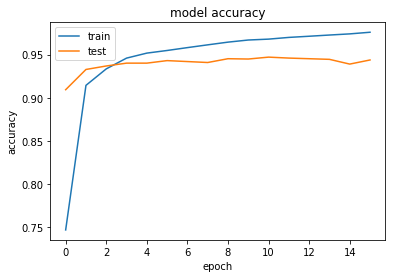

In [540]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

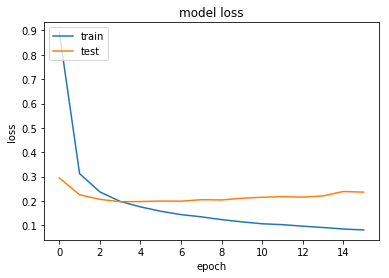

In [541]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Confusion matrix

In [563]:
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
name='MLP'

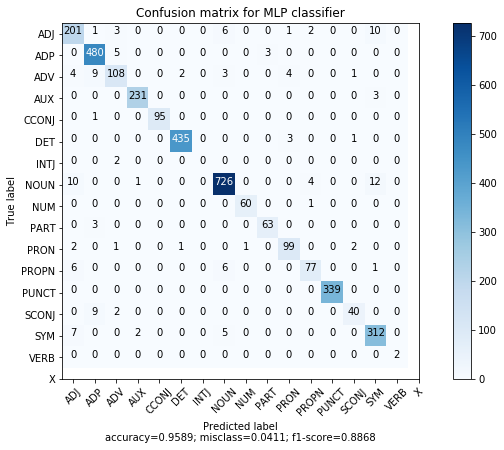

In [569]:
plot_confusion_matrix(f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro'), cnf_matrix, target_names=classes, title='Confusion matrix for '+name+' classifier', normalize=False)

## Tag an uknown sentence

Lets try the predicting power of our trained tagger:

In [544]:
test_sentence = nltk.word_tokenize('Word embeddings provide a dense representation of words and their relative meanings.'.lower())

In [545]:
X_test_sentence = transform_test_sentence(test_sentence, window=1)

In [546]:
X_embs = [x[1][0] for x in X_test_sentence]
X_embs = np.asarray(X_embs)
X_test_sentence = X_embs

In [547]:
pred = model.predict_classes(X_test_sentence, batch_size=1, verbose=1)

13/13 [==============================] - 0s 2ms/step


In [548]:
print('Here is what our MLP tagger predicts for the test sentence:\n',list(zip(test_sentence, le.inverse_transform(pred))))

Here is what our MLP tagger predicts for the test sentence:
 [('word', 'NOUN'), ('embeddings', 'NOUN'), ('provide', 'VERB'), ('a', 'DET'), ('dense', 'ADJ'), ('representation', 'NOUN'), ('of', 'ADP'), ('words', 'NOUN'), ('and', 'CCONJ'), ('their', 'DET'), ('relative', 'ADJ'), ('meanings', 'NOUN'), ('.', 'PUNCT')]


MLP Tagger works very nice!